# Analysis of Relational Cross-Attention

## Set up

In [1]:
from data_utils import q_text_vectorizer, a_text_vectorizer, load_dataset, invert_seq_vector
from model_utils import fetch_model, recompile_model, autoregressive_predict

import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('Solarize_Light2')

2023-09-10 18:16:47.814273: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-10 18:16:47.816254: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 18:16:47.857903: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 18:16:47.858726: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 18:16:48.785364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [11]:
def get_rel_attn_scores(model, test_source):
    '''gets relational cross-attention attn scores from relational abstracter model'''
    embedded_source = model.source_embedder(test_source)
    symbols = np.random.random(size=(1,160,128))
    _, attention_scores = model.abstractor.abstracter_layers[0].relational_crossattention.mha(
        query=embedded_source,
        key=embedded_source,
        value=symbols,
        return_attention_scores=True)
    seq_len = min(np.where(test_source==0)[1])
    rel_attn_scores = np.transpose(attention_scores[0,:,:seq_len, :seq_len])
    return rel_attn_scores

In [12]:
def plot_rel_attn_scores(model, test_source, get_rel_attn_scores):
    rel_attn_scores = get_rel_attn_scores(model, test_source)
    n_heads = np.shape(rel_attn_scores)[-1]
    fig, axs = plt.subplots(ncols=n_heads, figsize=(5*n_heads, 5))
    for head, ax in zip(range(n_heads), axs):
        ax.imshow(rel_attn_scores[:, :, head])
        ax.set_xticks(range(seq_len)); ax.set_yticks(range(seq_len))
        ax.set_xticklabels(list(test_source_text))
        ax.set_yticklabels(list(test_source_text))
        ax.set_title(f'head {head}')

    return fig, rel_attn_scores

## `polynomials__expand`

In [2]:
task = 'polynomials__expand'
train_ds, val_ds = load_dataset(task, train_size=-1, batch_size=512)

artifact_path = 'awni00/math-polynomials__expand/model-soft-moon-15:latest'
model = fetch_model(artifact_path, artifact_root_dir='model_artifacts')
model = recompile_model(model, a_text_vectorizer)

wandb:   5 of 5 files downloaded.  


In [3]:
test_source_text = 'Expand (3*x - 2)*(x + 1).'
test_source = q_text_vectorizer([[test_source_text]])
test_label = a_text_vectorizer([['@3*x**2 + x - 2;']])
test_target = test_label[:, :-1]
test_label = test_label[:, 1:]
preds = model_utils.autoregressive_predict(model, test_source, test_target)

In [4]:
tf_pred = model.predict([test_source, test_target], verbose=False).argmax(axis=-1)
invert_seq_vector(tf_pred[0], a_text_vectorizer)

'6*x**2;+;3;+;3;'

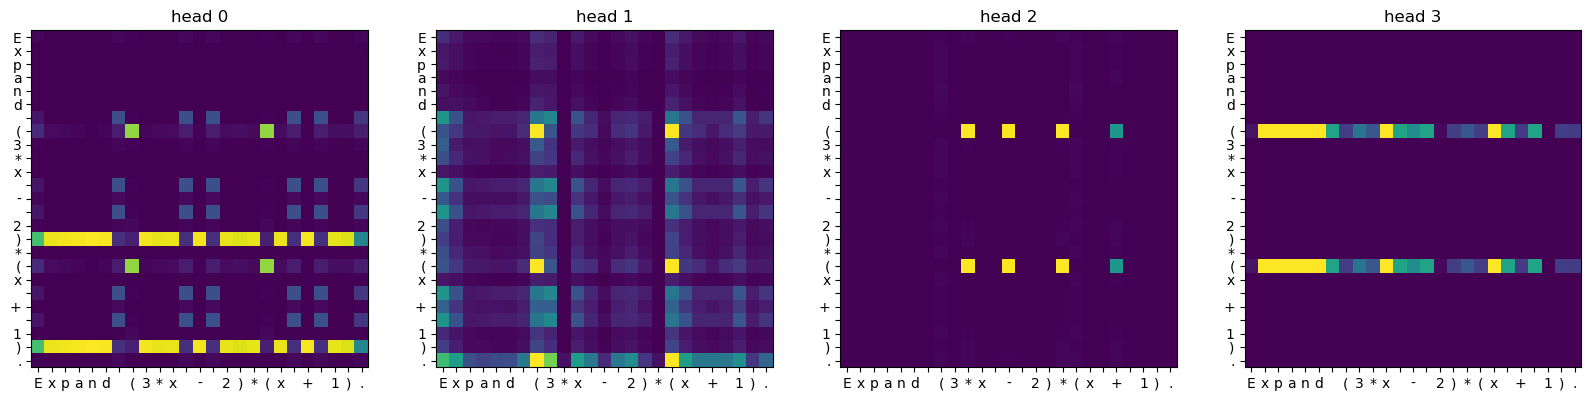

In [15]:
fig, rel_attn_scores = plot_rel_attn_scores(model, test_source, get_rel_attn_scores);